# COMMON MISTAKES WHILE USING PYTORCH

## 1. Not trying to overfit a single batch first
#### When you overfit a single batch — you’re making sure the architecture works. The results you’ll get are a good guess for the optimal performance of your architecture when it perfectly memorizes the input.
#### here’s why you should start out by over-fitting on a small subset of your dataset:


> Uncover silly bugs  



> Estimate the best possible loss/accuracy of current architecture.



> Fast iteration to improve the aforementioned.


## 2. Forget to toggle train/eval mode for the net. - PyTorch

#### Dropout layers are used so that the neurons can't rely on one input because it might be dropped out at random. This reduces bias due to over-relying on one input, bias is a major cause of overfitting.

In [1]:
# code snippet where .train() is called outside the for loop which leads to
# being stuck in eval mode until the next time the train function is called
# during the next epoch. This causes the drop-out to only occur once every epoch

def train(model, optimizer, epoch, train_loader, validation_loader):
    model.train() # 👈👈👈
    for batch_idx, (data, target) in experiment.batch_loop(iterable=train_loader):
        data, target = Variable(data), Variable(target)
        # Inference
        output = model(data)
        loss_t = F.nll_loss(output, target)
        # The iconic grad-back-step trio
        optimizer.zero_grad()
        loss_t.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            train_loss = loss_t.item()
            train_accuracy = get_correct_count(output, target) * 100.0 / len(target)
            experiment.add_metric(LOSS_METRIC, train_loss)
            experiment.add_metric(ACC_METRIC, train_accuracy)
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx, len(train_loader),
                100. * batch_idx / len(train_loader), train_loss))
            with experiment.validation():
                val_loss, val_accuracy = test(model, validation_loader) # 👈👈👈
                experiment.add_metric(LOSS_METRIC, val_loss)
                experiment.add_metric(ACC_METRIC, val_accuracy)


def test(model, test_loader):
    model.eval()
    # ...

The fix is easy — we move the model.train() one line down and into the training loop. The ideal is to have the mode set as close as possible to the inference step, to avoid forgetting to set it.

 #### In TensorFlow 2.0, you **don't need to manually control dropout** during training and testing as TensorFlow handles it seamlessly. The dropout layer automatically behaves differently based on the training phase.
During testing (or prediction), TensorFlow automatically disables dropout, ensuring consistent behavior on the test set.

## 3. Forget to do .zero_grad() before .backward()

#### When calling “backward” on the “loss” tensor, you’re telling PyTorch to go back up the graph from the loss, and calculate how each weight affects the loss. That’s the gradient for each node of the computational graph. Using this gradient we can optimally update the weights. Answering how much to increase or decrease every weight in the graph.

In [ ]:
output = model(input) # forward-pass
loss_fn.backward()    # backward-pass
optimizer.step()      # update weights by an ever growing gradient 📍🔥💥

The “step” method there at the end will update the weights based on results from the “backward” step. What might not be obvious from this code is that if we keep doing this over and over many batches, the gradient will explode, the step we take will keep growing and growing.

To avoid the step growing uncontrollably, we use the zero_grad method.

In [ ]:
output = model(input) # forward-pass
optimizer.zero_grad() # reset gradient 🧠
loss_fn.backward()    # backward-pass
optimizer.step()      # weight updates using reasonable gradients 👍

One way to make sure you didn’t fudge this is to always have these three functions go together:



1.   zero_grad
2.   backward
3.   step









## 4. Passing softmaxed outputs to a loss that expects raw logits.

Logits are the activations of the last fully connected layer. And softmax is those same activations but after a normalization.

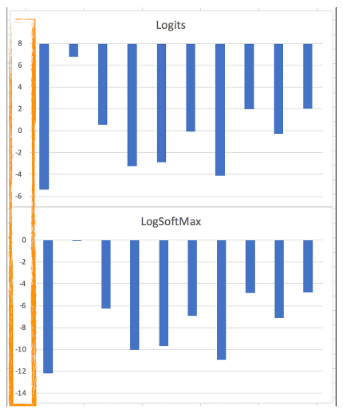

The top list is logits values, you can see some are positive and some are negative. The second list is the log-soft-maxed values. They’re all negative. Looking at the bar chart — they’re practically the same, the only difference is scale. But because of this subtle difference — all the math breaks apart.

In [ ]:
model = SuperSimpleClassifier(4, 3, 64)

#nn.CrossEntropyLoss() is for raw model outputs that do not go through a softmax function
criterion = nn.CrossEntropyLoss()

#If your model includes Softmax as a part of its computation then use NLLLoss() — negative log-likelihood loss
criterion = nn.NLLLoss()

optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-3)

## 5. Difference in Device Management while transitioning from TensorFlow to PyTorch

#### Device utilization is one area in which these frameworks differ; using TensorFlow, if a GPU is available, the framework will automatically utilize it when performing tensor operations, this applies to manual operations, and to the inner workings of DL models as well.
#### With PyTorch on the other hand, the user must manually “move” variables and models to the GPU if they require the operations to be performed by it rather than the CPU. This can be done quite simply in a variety of ways as shown below:

In [ ]:
# #Suppose this model building function is defined
model = get_model() #This model will not be on the GPU

model = get_model().to('cuda') #This model's weights will be on the GPU
#or
model = get_model().cuda() #This model's weights will also be on the GPU

## 6. Device Consistency Requirements - PyTorch

#### All variables involved in a computation must be on the same device, or else PyTorch will throw an error:

In [1]:
import torch

a = torch.tensor([1, 3, 5, 7]).to('cuda')
b = torch.tensor([0, 2, 4, 8])

# will give an error
c = a + b
print(c)

RuntimeError: ignored

## 7. Not Using Early Stopping

Early stopping is a technique used to prevent overfitting in neural networks. The idea is to stop training the model when the validation loss increases, which indicates that the model is starting to overfit the training data.

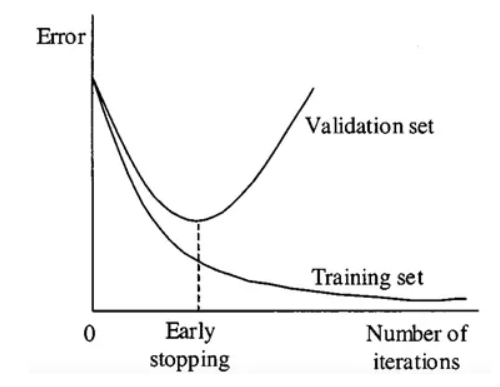

In PyTorch, you can implement early stopping by monitoring the validation loss and using a loop to stop training when the validation loss increases.

In [ ]:
best_val_loss = float("inf")
for epoch in range(num_epochs):
    train_loss = train(model, train_data, loss_fn, optimizer)
    val_loss = evaluate(model, val_data, loss_fn)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
    else:
        break


In TensorFlow, you can implement early stopping using the EarlyStopping callback from the tf.keras.callbacks module. This automates the process of monitoring the validation loss and stopping the training when certain criteria (like an increase in validation loss) are met and eliminates the need for manual implementation, making it more convenient and efficient.







In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping
model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stopping])


## 8. Not Saving and Loading the Model

Saving and loading models in PyTorch or TensorFlow is essential for:

1. Persistence: Store learned parameters for reuse without retraining.
2. Reproducibility: Share and reproduce results by saving and loading models.
3. Deployment: Efficiently deploy trained models in production.
4. Fine-Tuning: Facilitate transfer learning and fine-tuning.
5. Checkpointing: Save model states during training for recovery.
6. Experimentation: Speed up development by comparing models and hyperparameters.
7. Versioning: Enhance collaboration and project manageability.






In [1]:
#PyTorch
torch.save(model.state_dict(), "model.pt")
model = MyModel()
model.load_state_dict(torch.load("model.pt"))

# TensorFlow 2.0
model.save_weights("model.h5")
new_model = MyModel()
new_model.load_weights("model.h5")

## 9. Not setting a random seed

#### If your predictions are not stable for the same input value during different iterations (epochs/batches), it is highly probable that your random values are varying during each iterations. Easiest way to address this is to set a global seed value for all the random values in the graph.

In [ ]:
#Tensorflow

# should be set before any declaration of
# placeholders/variables/ops.

seed_value = 42  # or any seed value you choose
# Set the random seed
tf.random.set_seed(seed_value)

#PyTorch

seed_value = 42  # or any seed value you choose
# Set the random seed
torch.manual_seed(seed_value)

The seed value can also be set at operation level , tensorflow has a parameter for seed value in all the random operation.